# Data analysis
This jupyter notebook will quanitfy and analyze the alpha generated by different actively managed mutual funds.  These mutual funds were chosen through a process that Richard will detail.

The goal of the project is two-fold.
- Determine the portion of returns for a given strategy that arises from exposure to various market or systematic risk factors
- Identify and quanityf the 'idiosyncratic alpha'

In [9]:
from tools import get_mutual_fund_data, get_bond_data, get_ff_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import data
First, we import data using the tools that Richard wrote.  This allows us to get mutual fund data in a dictionary.  In addition, we also want FF factors and CAPM factors to do some basic analysis

In [10]:
mf_dict = get_mutual_fund_data()
ff_df = get_ff_data()
bond_df = get_bond_data()


Mutual Fund Data
Total mutual fund categories:  20
Total number of rows:  8209

Bond Data
          date  30 Year Bond Return  ...  CPI Return  CPI Index Level
0   1961-01-31            -0.012612  ...    0.000000             70.1
1   1961-02-28             0.024233  ...    0.000000             70.1
2   1961-03-30            -0.000238  ...    0.000000             70.1
3   1961-04-28             0.015599  ...    0.000000             70.1
4   1961-05-31             0.009878  ...    0.000000             70.1
..         ...                  ...  ...         ...              ...
739 2022-08-31            -0.053490  ...   -0.000354            696.9
740 2022-09-30            -0.085155  ...    0.002151            698.4
741 2022-10-31            -0.065624  ...    0.004056            701.2
742 2022-11-30             0.077931  ...   -0.001010            700.5
743 2022-12-30            -0.035953  ...   -0.003070            698.3

[744 rows x 21 columns]


## Data set
Let us first take a look at our data set to see what we are working with.  We are only working with actively managed funds and primarily those with the largest AUM.

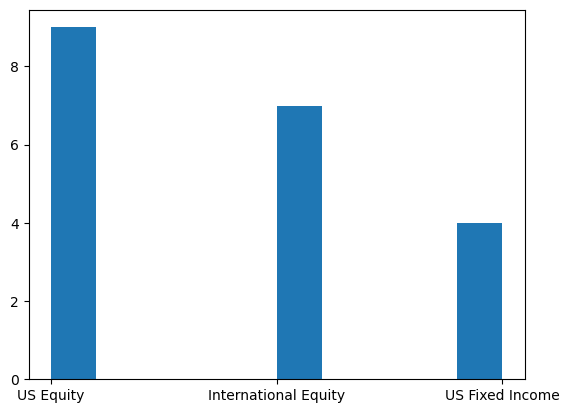

In [11]:
mf_types = list(mf_dict.keys())
mf_areas = [arr[0] for arr in mf_types]
plt.hist(mf_areas)
plt.show()

### Example df below

In [12]:
mf_dict[mf_types[10]]

,ticker,date,total_net_assets,total_returns,net_asset_value
0,MDIDX,2023-07-31,3748.500,0.027199,22.66
1,MDIDX,2023-03-31,3554.800,0.031655,21.51
2,MDIDX,2023-04-30,3622.500,0.021850,21.98
3,MDIDX,2023-05-31,3494.000,-0.035487,21.20
4,MDIDX,2023-02-28,3467.100,-0.038728,20.85
...,...,...,...,...,...
223,MDIDX,2005-02-28,120.800,0.046820,11.85
224,MDIDX,2005-01-31,94.600,-0.007888,11.32
225,MDIDX,2004-12-31,70.400,0.041922,11.41
226,MDIDX,2004-11-30,41.200,0.065700,11.03


## US Equity
First, let us look at those actively managed US equity funds

### Get US Equity Data

In [ ]:
mf_types = list(mf_dict.keys())